<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-1">Cross-Validation</a></span></li><li><span><a href="#Issues-with-Training-Error" data-toc-modified-id="Issues-with-Training-Error-2">Issues with Training Error</a></span></li><li><span><a href="#Train-Validation-Test-Split" data-toc-modified-id="Train-Validation-Test-Split-3">Train-Validation-Test Split</a></span></li><li><span><a href="#Training-Error-and-Test-Error" data-toc-modified-id="Training-Error-and-Test-Error-4">Training Error and Test Error</a></span></li><li><span><a href="#Feature-Selection-for-Ice-Cream-Ratings" data-toc-modified-id="Feature-Selection-for-Ice-Cream-Ratings-5">Feature Selection for Ice Cream Ratings</a></span></li><li><span><a href="#K-Fold-Cross-Validation" data-toc-modified-id="K-Fold-Cross-Validation-6">K-Fold Cross-Validation</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7">Summary</a></span></li></ul></div>

In [95]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

In [96]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [135]:
# HIDDEN
ice = pd.read_csv('icecream.csv')

## Feature Selection
In the previous section, we observe that the model cost on the training set, the dataset used to fit the model, can mislead. Adding more features to the data causes the training error to decrease. However, adding too many features causes overfitting—our model makes predictions based on patterns in the data generated by noise rather than the underlying phenomenon. 

## Issues with Training Error

Using degree 10 polynomial features on the dataset below results in a perfectly accurate model for the training data. Unfortunately, this model fails to generalize to previously-unseen data from the population.

In [98]:
# HIDDEN
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

trans_ten = PolynomialFeatures(degree=10)
X_ten = trans_ten.fit_transform(ice[['sweetness']])
y = ice['overall']

clf_ten = LinearRegression(fit_intercept=False).fit(X_ten, y)

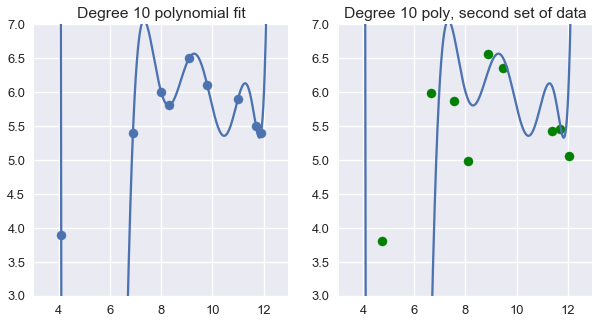

In [99]:
# HIDDEN
np.random.seed(1)
x_devs = np.random.normal(scale=0.4, size=len(ice))
y_devs = np.random.normal(scale=0.4, size=len(ice))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(ice['sweetness'], ice['overall'])
xs = np.linspace(3.5, 12.5, 1000).reshape(-1, 1)
ys = clf_ten.predict(trans_ten.transform(xs))
plt.plot(xs, ys)
plt.title('Degree 10 polynomial fit')
plt.ylim(3, 7);

plt.subplot(122)
ys = clf_ten.predict(trans_ten.transform(xs))
plt.plot(xs, ys)
plt.scatter(ice['sweetness'] + x_devs,
            ice['overall'] + y_devs,
            c='g')
plt.title('Degree 10 poly, second set of data')
plt.ylim(3, 7);

We cannot use the training error to pick features to add to the data since the training error will always favor more features. In order to accurately perform feature selection, we must check the model's error on data that is not used to fit the model.

## Train-Validation-Test Split

To accomplish this, we randomly split the original dataset into three disjoint subsets:

* Training set: The data used to fit the model.
* Validation set: The data used to select features.
* Test set: The data used to report the model's final accuracy.

After splitting, we select a set of features and a model based on the following procedure:

1. For each potential set of features, fit a model using the training set. The error of a model on the training set is its *training error*.
1. Check the error of each model on the validation set: its *validation error*. Select the model that achieves the lowest validation error. This is the final choice of features and model.
1. Calculate the *test error*, error of the final model on the test set. This is the final reported accuracy of the model. We are forbidden from adjusting the features or model to decrease test error; doing so effectively converts the test set into a validation set. Instead, we must collect a new test set after making further changes to the features or the model.

The validation set allows us to more accurately determine the set of features to keep in the final model than using the training error alone.

**Size of the train-validation-test split**

The train-validation-test split commonly uses 70% of the data as the training set, 15% as the validation set, and the remaining 15% as the test set. Increasing the size of the training set helps model accuracy but causes more variation in the validation and test error.

## Training Error and Test Error

A model is of little use to us if it fails to generalize to unseen data from the population. The test error provides an accurate representation of the model's performance on new data since we do not use the test set to train the model or select features.

In general, the training error decreases as we add complexity to our model with additional features or more complex prediction mechanisms. The test error, on the other hand, decreases up to a certain amount of complexity then increases again as the model overfits the training set.

![feature_train_test_error.png](https://raw.githubusercontent.com/DS-100/textbook/master/assets/feature_train_test_error.png)

## Feature Selection for Ice Cream Ratings

We use the complete model selection process, including cross-validation, to select a model that predicts ice cream ratings from ice cream sweetness. The complete ice cream dataset is shown below.

In [151]:
# HIDDEN
ice = pd.read_csv('icecream.csv')
transformer = PolynomialFeatures(degree=2)
X = transformer.fit_transform(ice[['sweetness']])
  
clf = LinearRegression(fit_intercept=False).fit(X, ice[['overall']])
xs = np.linspace(3.5, 12.5, 300).reshape(-1, 1)
rating_pred = clf.predict(transformer.transform(xs))

#ice.plot.scatter('sweetness', 'overall')
#plt.plot(xs, rating_pred)
#plt.title('Degree 2 polynomial fit');

temp = pd.DataFrame(xs, columns = ['sweetness'])
temp['overall'] = rating_pred

np.random.seed(42)
x_devs = np.random.normal(scale=0.2, size=len(temp))
y_devs = np.random.normal(scale=0.2, size=len(temp))
temp['sweetness'] = np.round(temp['sweetness'] + x_devs, decimals=2)
temp['overall'] = np.round(temp['overall'] + y_devs, decimals=2)

ice = pd.concat([temp, ice])

In [152]:
ice

,sweetness,overall
0,3.60,3.09
1,3.50,3.17
2,3.69,3.46
...,...,...
6,11.00,5.90
7,11.70,5.50
8,11.90,5.40


We've included a scatter plot of the overall rating versus ice cream sweetness below.

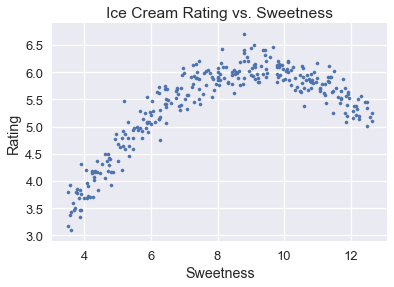

In [153]:
# HIDDEN
plt.scatter(ice['sweetness'], ice['overall'], s=10)
plt.title('Ice Cream Rating vs. Sweetness')
plt.xlabel('Sweetness')
plt.ylabel('Rating');

We first partition our data into a training dataset, validation dataset, and test dataset using `scikit-learn`'s [`sklearn.model_selection.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method to perform a 70/15/15% train-validation-test split.

In [154]:
from sklearn.model_selection import train_test_split

valid_size, test_size = 46, 46

# To perform a three-way split, we need to call train_test_split twice - once
# for the test set, one for the validation set.
X, X_test, y, y_test = train_test_split(
    ice[['sweetness']], ice['overall'], test_size=test_size)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=valid_size)

print(f'  Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_valid)}')
print(f'      Test set size: {len(X_test)}')

  Training set size: 217
Validation set size: 46
      Test set size: 46


We now fit polynomial regression models using the training set `X_train` and `y_train`, one for each polynomial degree from 1 to 10.

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# First, we add polynomial features to X_train
transformers = [PolynomialFeatures(degree=deg)
                for deg in range(1, 11)]
X_train_polys = [transformer.fit_transform(X_train)
                 for transformer in transformers]

# Display the X_train with degree 5 polynomial features
X_train_polys[4]

array([[     1.  ,      7.09,     50.27,    356.4 ,   2526.88,  17915.59],
       [     1.  ,      9.88,     97.61,    964.43,   9528.57,  94142.28],
       [     1.  ,     10.12,    102.41,   1036.43,  10488.71, 106145.74],
       ...,
       [     1.  ,     11.4 ,    129.96,   1481.54,  16889.6 , 192541.46],
       [     1.  ,      5.2 ,     27.04,    140.61,    731.16,   3802.04],
       [     1.  ,      9.86,     97.22,    958.59,   9451.65,  93193.28]])

In [156]:
# Next, we train a linear regression classifier for each featurized dataset.
# We set fit_intercept=False since the PolynomialFeatures transformer adds the
# bias column for us.
clfs = [LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)
        for X_train_poly in X_train_polys]

After training the models, we evaluate the mean squared error of each model on the validation set.

In [159]:
def mse_cost(y_pred, y_actual):
    return np.mean((y_pred - y_actual) ** 2)

# To make predictions on the validation set we need to add polynomial features
# to the validation set too.
X_valid_polys = [transformer.fit_transform(X_valid)
                 for transformer in transformers]

predictions = [clf.predict(X_valid_poly)
               for clf, X_valid_poly in zip(clfs, X_valid_polys)]

costs = [mse_cost(pred, y_valid) for pred in predictions]

In [164]:
# HIDDEN
cv_df = pd.DataFrame({'Validation Error': costs}, index=range(1, 11))
cv_df.index.name = 'Degree'
pd.options.display.max_rows = 20
display(cv_df)
pd.options.display.max_rows = 7

,Validation Error
Degree,
1,0.304539
2,0.043109
3,0.043629
4,0.043187
5,0.043868
6,0.043878
7,0.043909
8,0.044971
9,0.047573


We can see that as we use higher degree polynomial features, the validation error decreases and increases again.

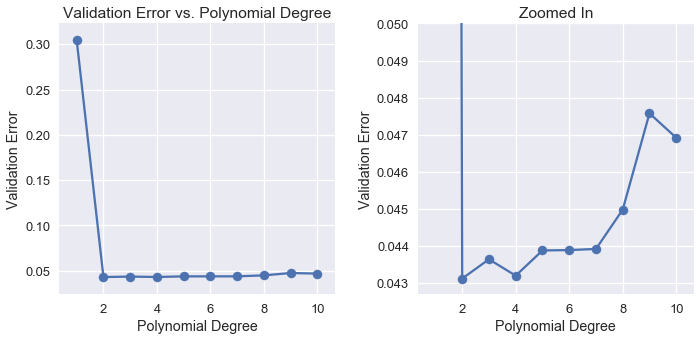

In [186]:
# HIDDEN
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(cv_df.index, cv_df['Validation Error'])
plt.scatter(cv_df.index, cv_df['Validation Error'])
plt.title('Validation Error vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error');

plt.subplot(122)
plt.plot(cv_df.index, cv_df['Validation Error'])
plt.scatter(cv_df.index, cv_df['Validation Error'])
plt.ylim(0.0427, 0.05)
plt.title('Zoomed In')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error')

plt.tight_layout();

Examining the validation errors reveals the most accurate model only used degree 2 polynomial features. Thus, we select the degree 2 polynomial model as our final model and report its test error.

In [196]:
best_trans = transformers[1]
best_clf = clfs[1]

training_error = mse_cost(best_clf.predict(X_train_polys[1]), y_train)
validation_error = mse_cost(best_clf.predict(X_valid_polys[1]), y_valid)
test_error = mse_cost(best_clf.predict(best_trans.transform(X_test)), y_test)

print('Degree 2 polynomial')
print(f'  Training error: {training_error:0.3f}')
print(f'Validation error: {validation_error:0.3f}')
print(f'      Test error: {test_error:0.3f}')

Degree 2 polynomial
  Training error: 0.042
Validation error: 0.043
      Test error: 0.063
